0.0 1.0


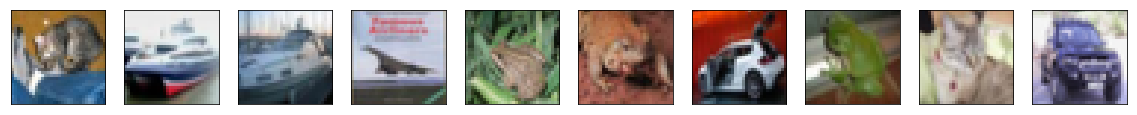

In [13]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def show_10_images(data):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(data[i].reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))

print(np.min(x_train), np.max(x_train))
show_10_images(x_test)

In [46]:
# Train VGG13
from classifier import create_model

classifer = create_model()
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

In [47]:
import os
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

weight_file = './weights/cifar10_classifier.hdf5'

if(os.path.exists(weight_file)):
    classifier.load_weights(weight_file)
else:
    classifier.fit(x_train, to_categorical(y_train),
                   epochs=200,
                   batch_size=128,
                   shuffle=True,
                   validation_data=(x_test, to_categorical(y_test)),
                   callbacks=[
        EarlyStopping(patience=10),
        ModelCheckpoint(
            "./weights/cifar10_classifier.{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True, save_weights_only=True)
    ])

    classifier.save_weights(weight_file)

In [48]:
loss, acc = classifier.evaluate(x_test, to_categorical(y_test), batch_size=128)

print("Model loss:", loss)
print("Model accuracy:", acc)

10000/10000 [==============================] - 3s 313us/step
Model loss: 0.9735289602279663
Model accuracy: 0.8717


# Calculate baseline softmax and ODIN AUROC

In [49]:
from keras.layers import Lambda, Input, Activation
from keras.models import Model, clone_model
import keras.backend as K
NUM_CLASSES = 10


def create_odin_model(epsilon, temperature):
    image = Input(shape=(32, 32, 3))
    image_cp = Lambda(lambda x: x)(image)

    new_classifier = clone_model(classifier)
    new_classifier.load_weights(weight_file)
    softmax = new_classifier.layers.pop()

    # Do first pass
    x = new_classifier(image_cp)

    # Get gradients wrt input image
    pred_target = Lambda(lambda x: K.one_hot(
        K.argmax(x, axis=1), num_classes=NUM_CLASSES))(x)
    loss = Lambda(lambda x: K.binary_crossentropy(
        x[0], x[1]))([pred_target, x])
    grad = Lambda(lambda x: K.gradients(loss, image_cp))(x)
    grad = Lambda(lambda x: x * epsilon)(grad)

    # Use gradient to perturb image then classify it
    x = Lambda(lambda x: x[0] - x[1])([image_cp, grad])
    x = new_classifier(x)

    # Do the temp scaling
    x = Lambda(lambda x: x / temperature)(x)
    x = Lambda(lambda x: x - K.max(x, axis=0))(x)
    output = softmax(x)

    return Model(inputs=image, outputs=output)

## Tiny Imagenet (Crop)

0.0 1.0


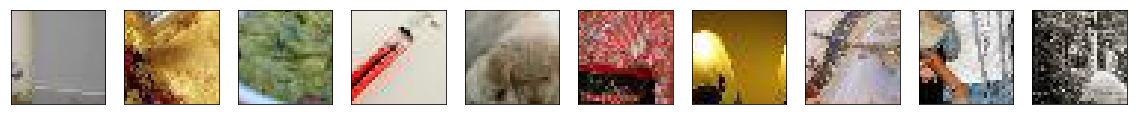

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

import torch
from torchvision import transforms, datasets

DATA_DIR = '/media/tadenoud/DATADisk/datasets'
use_cuda = True

directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_crop = transforms.Compose([
    transforms.RandomCrop([32, 32]),
    transforms.ToTensor()
])

# Load the dataset
imagenet_crop = datasets.ImageFolder(directory, transform=transform_crop)
imagenet_crop = np.array([np.array(x) for x, y in imagenet_crop])
imagenet_crop = imagenet_crop.astype('float32')# / 255.

imagenet_crop = np.swapaxes(imagenet_crop, 1, 3)
imagenet_crop = np.swapaxes(imagenet_crop, 1, 2)

print(np.min(imagenet_crop), np.max(imagenet_crop))
show_10_images(imagenet_crop)

In [20]:
labels = len(x_test) * [0] + len(imagenet_crop) * [1]
test_samples = np.concatenate((x_test, imagenet_crop))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.8501845950000001
ODIN AUROC: 0.98304035


## Tiny Imagenet (Resize)

0.0 1.0


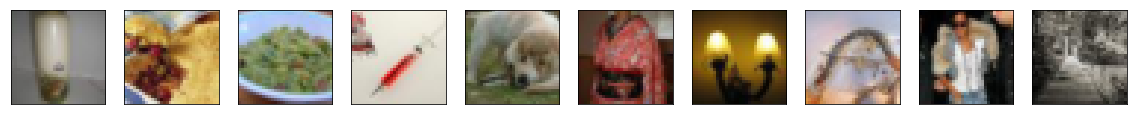

In [21]:
directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_resize = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor()
])

# Load the dataset
imagenet_resize = datasets.ImageFolder(directory, transform=transform_resize)
imagenet_resize = np.array([np.array(x) for x, y in imagenet_resize])
imagenet_resize = imagenet_resize.astype('float32')# / 255.

imagenet_resize = np.swapaxes(imagenet_resize, 1, 3)
imagenet_resize = np.swapaxes(imagenet_resize, 1, 2)

print(np.min(imagenet_resize), np.max(imagenet_resize))
show_10_images(imagenet_resize)

In [22]:
labels = len(x_test) * [0] + len(imagenet_resize) * [1]
test_samples = np.concatenate((x_test, imagenet_resize))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.82721033
ODIN AUROC: 0.8815321


## LSUN (Crop)

(10000, 3, 32, 32)
0.0 1.0


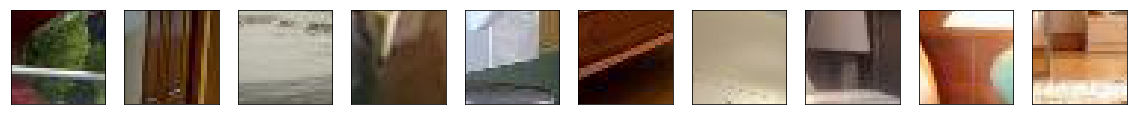

In [30]:
# Load the dataset
lsun_crop = datasets.LSUN(os.path.join(DATA_DIR, 'lsun'), classes='test', transform=transform_crop)
lsun_crop = np.array([np.array(x) for x, y in lsun_crop])
lsun_crop = lsun_crop.astype('float32')# / 255.

print(lsun_crop.shape)
lsun_crop = np.swapaxes(lsun_crop, 1, 3)
lsun_crop = np.swapaxes(lsun_crop, 1, 2)

print(np.min(lsun_crop), np.max(lsun_crop))
show_10_images(lsun_crop)

In [31]:
labels = len(x_test) * [0] + len(lsun_crop) * [1]
test_samples = np.concatenate((x_test, lsun_crop))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.907842225
ODIN AUROC: 0.9899475350000001


## LSUN (Resize)

0.0 1.0


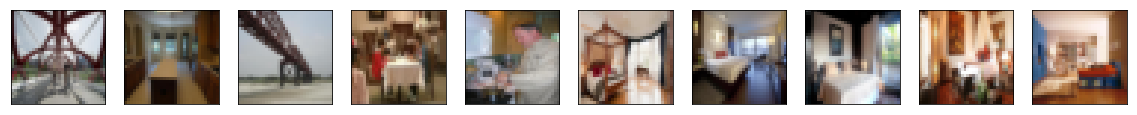

In [32]:
# Load the dataset
lsun_resize = datasets.LSUN(os.path.join(DATA_DIR, 'lsun'), classes='test', transform=transform_resize)
lsun_resize = np.array([np.array(x) for x, y in lsun_resize])
lsun_resize = lsun_resize.astype('float32')# / 255.

lsun_resize = np.swapaxes(lsun_resize, 1, 3)
lsun_resize = np.swapaxes(lsun_resize, 1, 2)

print(np.min(lsun_resize), np.max(lsun_resize))
show_10_images(lsun_resize)

In [33]:
labels = len(x_test) * [0] + len(lsun_resize) * [1]
test_samples = np.concatenate((x_test, lsun_resize))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.824232245
ODIN AUROC: 0.9660521650000001


## iSUN (Resize)

0.0 1.0


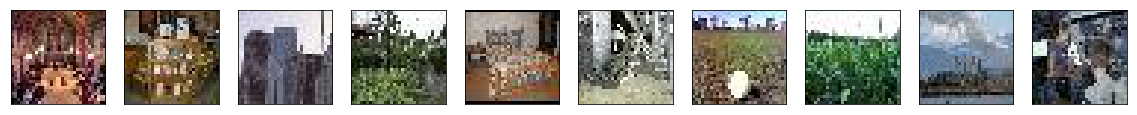

In [34]:
directory = os.path.join(DATA_DIR, 'isun')

# Load the dataset
isun_resize = datasets.ImageFolder(directory, transform=transform_resize)
isun_resize = np.array([np.array(x) for x, y in isun_resize])
isun_resize = isun_resize.astype('float32')# / 255.

isun_resize = np.swapaxes(isun_resize, 1, 3)
isun_resize = np.swapaxes(isun_resize, 1, 2)

print(np.min(isun_resize), np.max(isun_resize))
show_10_images(isun_resize)

In [35]:
labels = len(x_test) * [0] + len(isun_resize) * [1]
test_samples = np.concatenate((x_test, isun_resize))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.8321660280112044
ODIN AUROC: 0.9820124593837536


## Gaussian noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

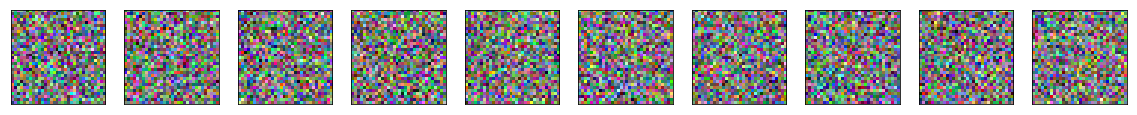

In [38]:
cifar10_mean = np.mean(x_train)
cifar10_std = np.std(x_train)
gaussian_data = np.random.normal(
    cifar10_mean, cifar10_std, size=(10000, 32, 32, 3))

guassian_data = np.clip(gaussian_data, 0., 1.)

show_10_images(gaussian_data)

In [39]:
labels = len(x_test) * [0] + len(gaussian_data) * [1]
test_samples = np.concatenate((x_test, gaussian_data))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.6716647849999999
ODIN AUROC: 0.999830695


## Uniform noise

CIFAR10 mean: 0.4733649
Uniform mean: 0.47329628201226404
CIFAR10 std: 0.25156906
Uniform std: 0.2516181454411939


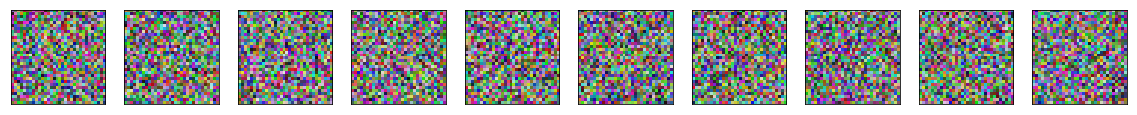

In [42]:
import math
b = math.sqrt(3.) * cifar10_std
a = -b + cifar10_mean
b += cifar10_mean

uniform_data = np.random.uniform(low=a, high=b, size=(10000, 32, 32, 3))

print("CIFAR10 mean:", cifar10_mean)
print("Uniform mean:", np.mean(uniform_data))
print("CIFAR10 std:", cifar10_std)
print("Uniform std:", np.std(uniform_data))

show_10_images(uniform_data)

In [43]:
labels = len(x_test) * [0] + len(uniform_data) * [1]
test_samples = np.concatenate((x_test, uniform_data))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.66762676
ODIN AUROC: 0.9998336
